In [10]:
# initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram


IBMQ.save_account('ad3965ae3913db06521d71bba9e1208319b91a9e7ab869744cd624d63a8e898cfef58312e0819dcc2a1a2ffa59a867a4fdf5f6e225c6f2c80f28e03d3bb1a61a',overwrite=True)

#IBMQ.save_account('ebadbf7da56bb61d559a2f5fecd3d1d6e60d13ce5dd374f801829f3c92cd864b124e1ad5c1fd3faa6a14a5365f9d326947df8db138604049b06192da43d6a49b',overwrite=True)

#IBMQ.save_account('676f27667e5b533a92387a7716d67080d9648d217e96873f767e3834c2861bd4590a7ffbff31002cbce3f215642436c9a2e3a731e24b797ed5acd92765a463c2',overwrite=True)
#IBMQ.save_account('ebadbf7da56bb61d559a2f5fecd3d1d6e60d13ce5dd374f801829f3c92cd864b124e1ad5c1fd3faa6a14a5365f9d326947df8db138604049b06192da43d6a49b',overwrite=True)



IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends() 

ibmqfactory.load_account:WARNING:2020-08-06 20:57:54,316: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [11]:
from qiskit import *

In [12]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

In [13]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [14]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)


n=1
qr = QuantumRegister(n)
cr = ClassicalRegister(n)
    
circuit = QuantumCircuit(qr, cr)
barriers = True


            # Apply Hadamard gate
circuit.h(qr)    
    

            # Apply Z-gate 
circuit.z(qr)  

            # Apply barrier 


            # Apply Hadamard gate
circuit.h(qr) 

            # Measure the register
    
for i in range(n):
    circuit.measure(qr[i], cr[i])

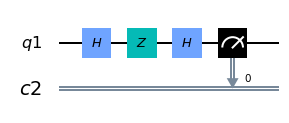

In [15]:
circuit.draw('mpl')

In [16]:
provider = IBMQ.get_provider(hub='ibm-q')
#device = provider.get_backend('ibmq_vigo')

In [21]:
FidelityFull1=[]
FidelityPartial1=[]
FidelityNoisy1=[]

JobIDFull1=[]
JobIDPartial1=[]
JobID_DJA1=[]

MatrixFull1=[]
MatrixPartial1=[]

In [22]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circuits, state_labels = complete_meas_cal(qr=circuit.qregs[0], 
                                               circlabel='measurement_calibration')
device = provider.get_backend('ibmq_vigo')
bit='1'

for j in range (0,14):
    #for j in range (0,14):
    
    Trials=2**j  
    #Trials=8192
    
    job = execute(circuit, backend=device, shots=Trials)
    device_result = job.result()
    
    
    cal_job = execute(cal_circuits,
             backend=device,
             shots=Trials,
             optimization_level=0)
    #print(cal_job.job_id())

    cal_results = cal_job.result()

    index=2**n-1
    cal_job_partial = execute(cal_circuits[index],
             backend=device,
             shots=Trials,
             optimization_level=0)
    cal_results_partial = cal_job_partial.result()
    #JobIDPartial.append(cal_job_partial.job_id())
   
    meas_fitter = CompleteMeasFitter(cal_results, state_labels)
    meas_fitter_partial = CompleteMeasFitter(cal_results_partial, state_labels)
    for k in range (2**n-1):
        meas_fitter_partial.cal_matrix[k,k]=1
        
    
    meas_filter_partial =meas_fitter_partial.filter
    mitigated_result_partial = meas_filter_partial.apply(device_result)
    mitigated_counts_partial = mitigated_result_partial.get_counts(circuit)
    
    meas_filter =meas_fitter.filter
    mitigated_result = meas_filter.apply(device_result)
    mitigated_counts = mitigated_result.get_counts(circuit)
    
    if bit in device_result.get_counts(circuit):
        FidelityNoisy1.append(device_result.get_counts(circuit).get(bit)/Trials)
    else:
        FidelityNoisy1.append(0)
    
    if bit in mitigated_counts_partial.keys():
        FidelityPartial1.append(mitigated_counts_partial.get(bit)/Trials)
    else:
        FidelityPartial1.append(0)
    
    if bit in mitigated_counts.keys():
        FidelityFull1.append(mitigated_counts.get(bit)/Trials)
    else:
        FidelityFull1.append(0)
    
    JobIDFull1.append("'"+str(cal_job.job_id())+"'")
    JobIDPartial1.append("'"+str(cal_job_partial.job_id())+"'")
    JobID_DJA1.append("'"+str(job.job_id())+"'")
    
    MatrixFull1.append(meas_fitter.cal_matrix)
    MatrixPartial1.append(meas_fitter_partial.cal_matrix)

KeyboardInterrupt: 

In [ ]:
def MatlabStr(array):
    return '[' + "; ".join(" ".join("%6g" % val for val in line) for line in array) + ']'

In [ ]:
print(FidelityFull1)
print(FidelityPartial1)
print(FidelityNoisy1)

print(JobIDFull1)
print(JobIDPartial1)
print(JobID_DJA1)

print(MatrixFull1)
print(MatrixPartial1)

In [ ]:
FullMatlab=[]
PartialMatlab=[]

In [ ]:
for j in MatrixFull1:
    print(MatlabStr(j))



In [ ]:
FullMatlab

In [ ]:
PartialMatlab

# Here I put the full matrices

In [ ]:
for j in MatrixFull1:
    print(MatlabStr(j))

# Here the partial

In [ ]:
for j in MatrixPartial1:
    print(MatlabStr(j))